# Time Series Modeling Performance Assessment

### John Foster
### Department of Information Technology, Western Governors University
### D213: Advanced Data Analytics
### Professor William Sewell
### June 30, 2023

### A1: RESEARCH QUESTION

The research question that I have chosen to pursue using the teleco_time_series.csv time series dataset is as follows:

“With what degree of accuracy can we predict the daily revenue of the organization using an Auto Regressive Integrated Moving Average (ARIMA) model and 731 days of recorded revenue data?”

The underlying business need addressed by this research question is primarily related to financial planning within the organization. By establishing an accurate model for forecasting revenue, long term strategic initiatives can be implemented to prepare for anticipated expenditures and methodically plan the sustainable scaling of staffing and infrastructure according to projected revenue growth.

### A2: OBJECTIVES OR GOALS

Because answering our research question requires us to create a test in order to determine the accuracy of the ARIMA model, our primary objectives for this analysis will be as follows:

First, we will split the time series data into train and test sets. The training set will consist of the first 80 percent of the time series, with the test set consisting of the final 20 percent. This will allow us to fit the regression to the majority of the data set, then attempt to forecast the trendline of the remaining time series data.

To evaluate the accuracy of the model, we will calculate the residuals of the forecast predictions against the actual revenue data of the test dataset, then compute the mean absolute error of the model. A comparison of the MAE to the total range of the revenue data will allow us to evaluate the performance of the model and answer our research question. For the purposes of establishing a concrete goal, we will aim to produce a model with an MAE of less than 15% of the total range of revenue data in the time series.

### B: SUMMARY OF ASSUMPTIONS

Time series models can be characterized by several important assumptions. We will list and summarize these assumptions below.

- The data should not contain outliers or major anomalies. 

- The data must exhibit stationarity, meaning it cannot display trending or seasonality. This poses an obstacle in our own analysis, which actually will display a clear trend in the data. To compensate for this, we will employ a technique called differencing in order to ensure that this assumption is satisfied. 

- The data must exhibit homoscedasticity, meaning that the variance of the model’s residuals should be constant over time, and across time periods. 

- There is a linear relationship between past data and future data, meaning that a regression generated on past data can be iteratively extended to forecast future data. In our analysis, this assumption will ultimately be tested by splitting our data into training and testing sets.

### C1: LINE GRAPH VISUALIZATION

The following code snippets will generate the line graph reflecting the raw values of the time series data set:

In [1353]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
import scipy.stats as stats

#Import our time series
df = pd.read_csv('teleco_time_series .csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731 entries, 0 to 730
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Day      731 non-null    int64  
 1   Revenue  731 non-null    float64
dtypes: float64(1), int64(1)
memory usage: 11.5 KB


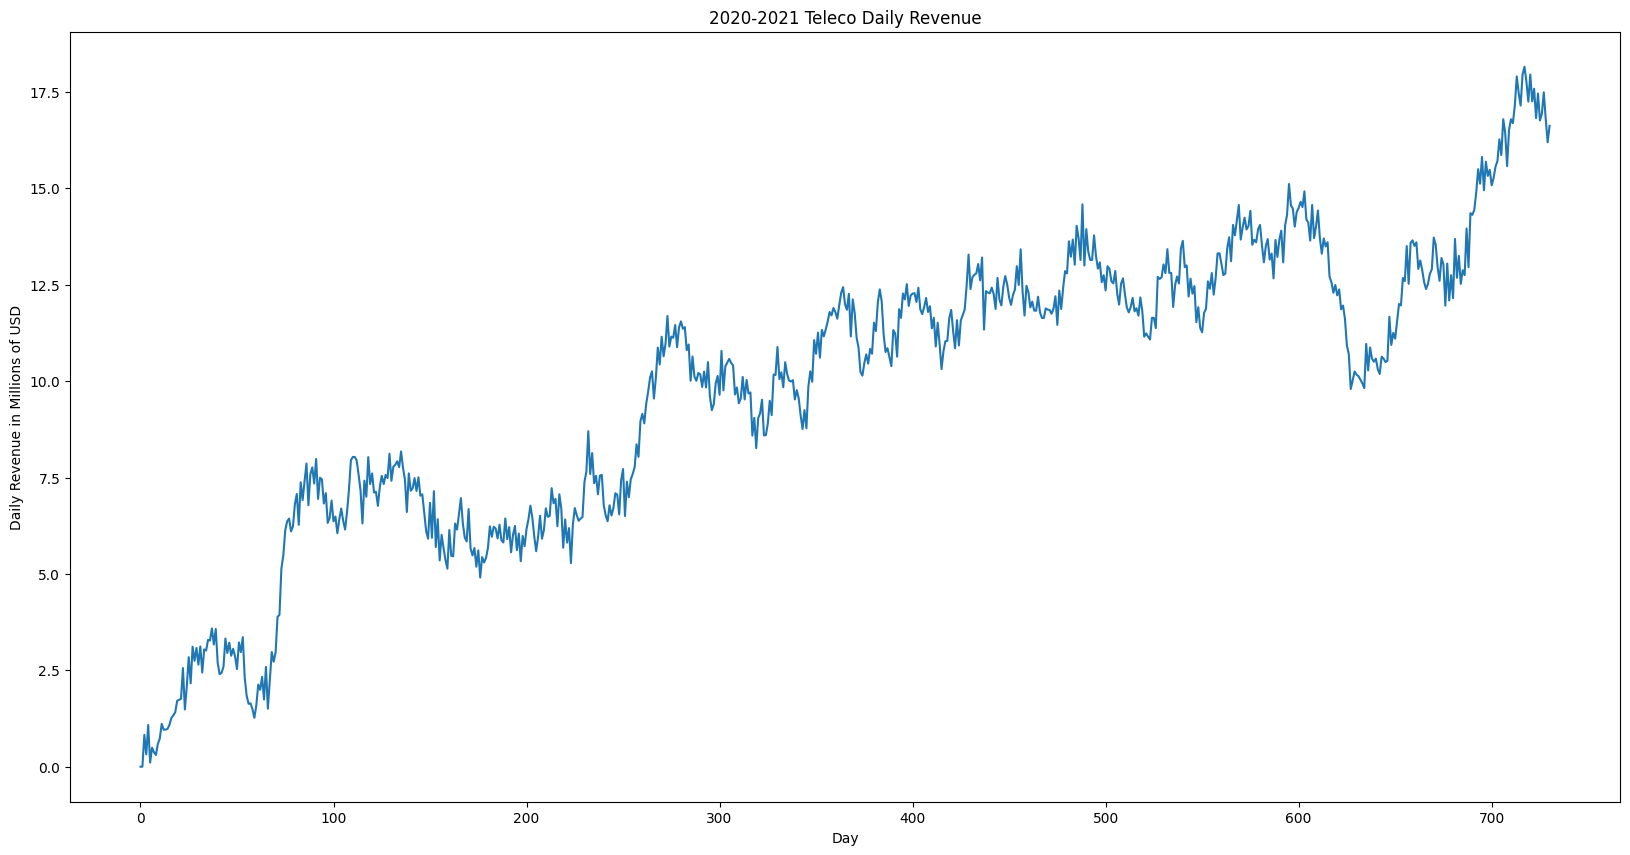

In [1354]:
plt.figure(figsize = [20,10])
plt.plot(df['Revenue'])
plt.title("2020-2021 Teleco Daily Revenue")
plt.xlabel("Day")
plt.ylabel("Daily Revenue in Millions of USD")
plt.show()

### C2: TIME STEP FORMATTING

The teleco_time_series.csv dataset contains 2 columns, titled ‘Day’ and ‘Revenue’. According to the provided data dictionary, the ‘Day’ column functions effectively as an index, containing an integer value of the day number from the start of operations. The Revenue column contains floating point numbers of the revenue generated on each day of operation. As a point of note, 731 days has a remainder of 1 when divided by 365, leading us to conclude that one of the years in question is a leap year. For simplicity, when we transform our ‘Day’ column to DateTime values, we will treat the years of the data being evaluated as 2020-2021 to account for this.

There are no null values contained in this dataset, leading us to conclude that there are no gaps in our measurement of this time series to be interpolated or otherwise addressed.

In [1355]:
# Convert our Day column to datetime format for our model
t_start = pd.to_datetime('2020-01-01')
df['Day'] = pd.to_timedelta(df['Day']-1, unit='D') + t_start
df.set_index('Day', inplace=True)
print(df)

              Revenue
Day                  
2020-01-01   0.000000
2020-01-02   0.000793
2020-01-03   0.825542
2020-01-04   0.320332
2020-01-05   1.082554
...               ...
2021-12-27  16.931559
2021-12-28  17.490666
2021-12-29  16.803638
2021-12-30  16.194813
2021-12-31  16.620798

[731 rows x 1 columns]


### C3: STATIONARITY

As we can see from the graph generated below, there is a clear upward trend demonstrated in our data over these initial two years, which indicates that it does not satisfy our assumption of stationarity. The data begins its upward pattern of noise just above 0.0 and concludes at around 17.5, demonstrating only minimal corrections as it climbs upward.

When we perform an Augmented Dicky-Fuller test on the raw data in an attempt to reject a null hypothesis of non-stationarity, we return a test statistic of -1.9246. This statistic has a p-value of .3206, meaning that the null hypothesis cannot be rejected, and we cannot claim that the data exhibits stationarity with any degree of statistical certainty.

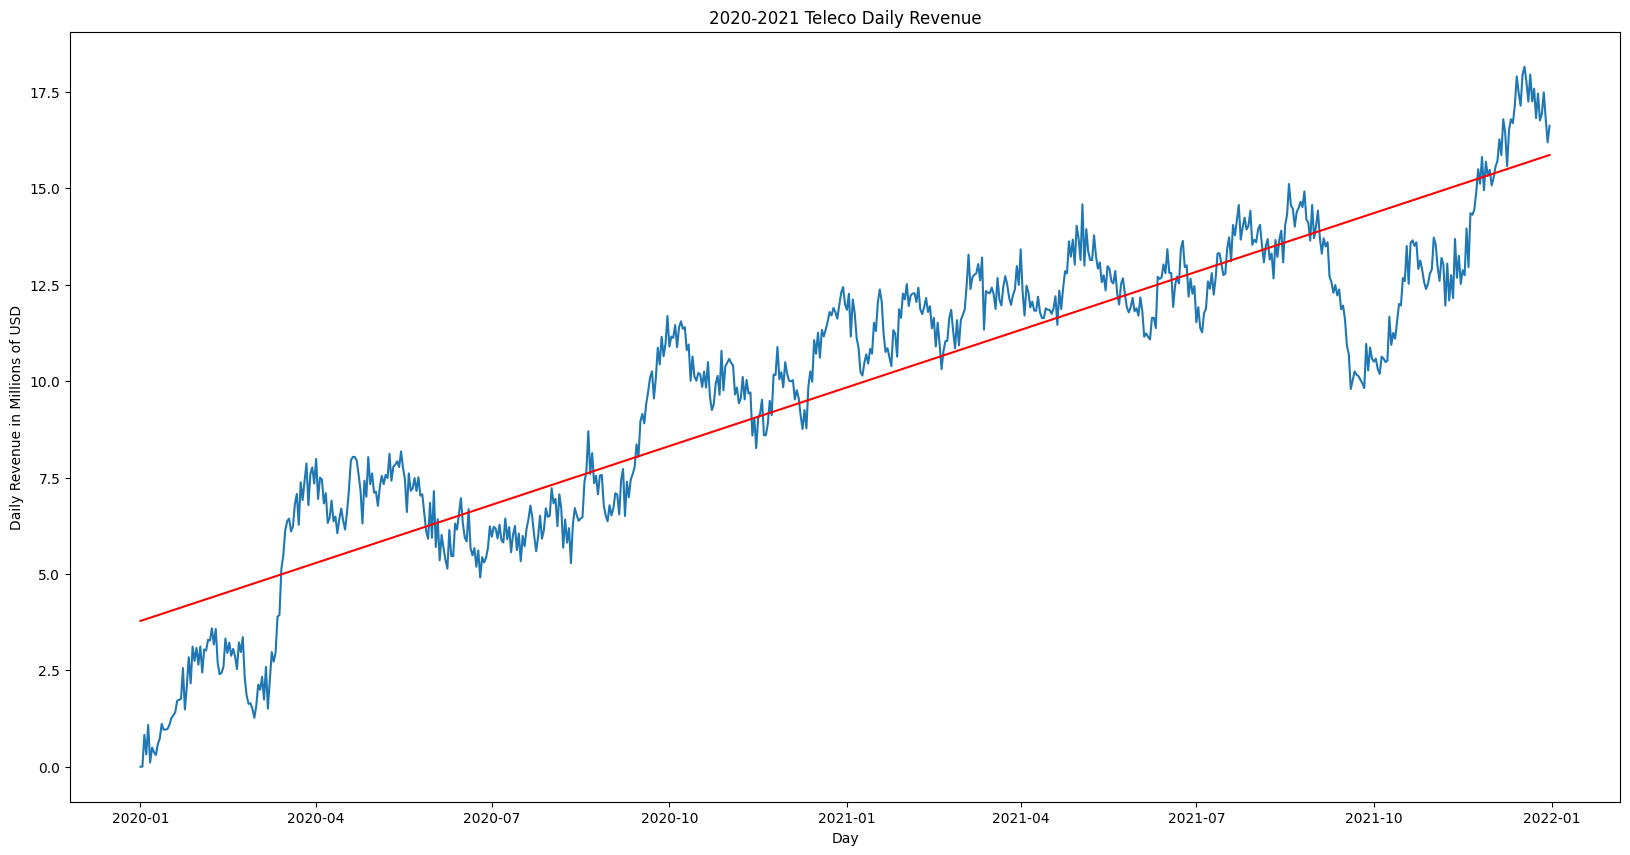

In [1356]:
# PLot our datetime transformed data with a trend line
plt.figure(figsize = [20,10])
plt.title("2020-2021 Teleco Daily Revenue")
plt.xlabel("Day")
plt.ylabel("Daily Revenue in Millions of USD")
plt.plot(df)
days = mdates.date2num(df.index)
# Code adapted from https://matplotlib.org/stable/api/dates_api.html#matplotlib.dates.date2num
revenue = df['Revenue']
z = np.polyfit(days, revenue, 1)
slope, intercept = np.polyfit(days, revenue, 1)
trendline = slope * days + intercept
plt.plot(days, trendline, color='r', label='Trend Line')
plt.show()

In [1357]:
# ADF testing the data
ADF = adfuller(df['Revenue'])
print('ADF statistic: ' + str(ADF[0]))
print('P-value of ADF statistic: ' + str(ADF[1]))

ADF statistic: -1.9246121573101809
P-value of ADF statistic: 0.32057281507939783


### C4: STEPS TO PREPARE THE DATA

We will employ several steps in order to prepare the data for analysis in our ARIMA model. We will briefly summarize these steps below.

We must re-express the ‘Day’ column as DateTime objects, starting from 1/1/2020 and ending on 12/31/2021. This column will function as the index for our time series dataframes. This was accomplished in the code contained in section C2.

We must next employ a technique called differencing to transform our ‘Revenue’ column into a series that demonstrates stationarity. To do this, we will effectively be subtracting each value in the column from the value that occurs one day before it. Because we are looking for a linear function to forecast the trend in our raw data, a dataset of the differences in values should hover around a consistent mean and demonstrate stationarity. This technique is essentially what distinguishes an ARIMA model from an ARMA model.

We must split our dataset into training and testing sets. We will fit our ARIMA model to perform a regression on the first 80 percent of the data, then generate a forecast on the remaining 20 percent of the dataset in order to test the efficacy of the model. It is important to split our training and testing data in this way, as random selection of training and testing samples would violate the basic assumptions of a time series model.

These steps will be demonstrated in sequence by executing the code snippets below.

ADF statistic: -44.874527193875984
P-value of ADF statistic: 0.0


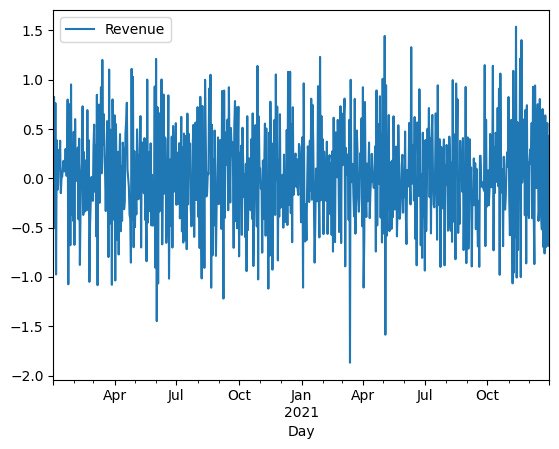

In [1358]:
#Apply differencing
df_processed = df.diff().dropna()

# ADF testing the data
ADF = adfuller(df_processed['Revenue'])
print('ADF statistic: ' + str(ADF[0]))
print('P-value of ADF statistic: ' + str(ADF[1]))

# Plot to verify stationarity
df_processed.plot()
plt.show()

In [1359]:
# Use train_test_split to divide the first 80% of the data into a training set 
# and the last 20% into a testing set
split_size=.2
X_train, X_test = train_test_split(df_processed, test_size=split_size, shuffle=False, random_state=0)

### C5: PREPARED DATA SET

The final prepared training and testing datasets will be exported to .csv files by executing the code snippet below. We will submit these files for evaluation along with this notebook via the WGU submission portal.

In [1360]:
#Export our dataframes to csv files
X_train.to_csv('training_series.csv')
X_test.to_csv('testing_series.csv')

### D1: REPORT FINDINGS AND VISUALIZATIONS

In analyzing the time series data, we can make several conclusions about various facets of the data. We will summarize these findings below, along with code snippets to demonstrate them visually.

#### Seasonality

When we decompose the data using the seasonal_decompose function, we can see that the resulting visualization exhibits a consistent pattern, indicating seasonality. If we look closely, we can see roughly 14 cycles between 2020-01 and 2020-04, which indicates that this seasonality likely corresponds to weekly cycles related to revenue generation.

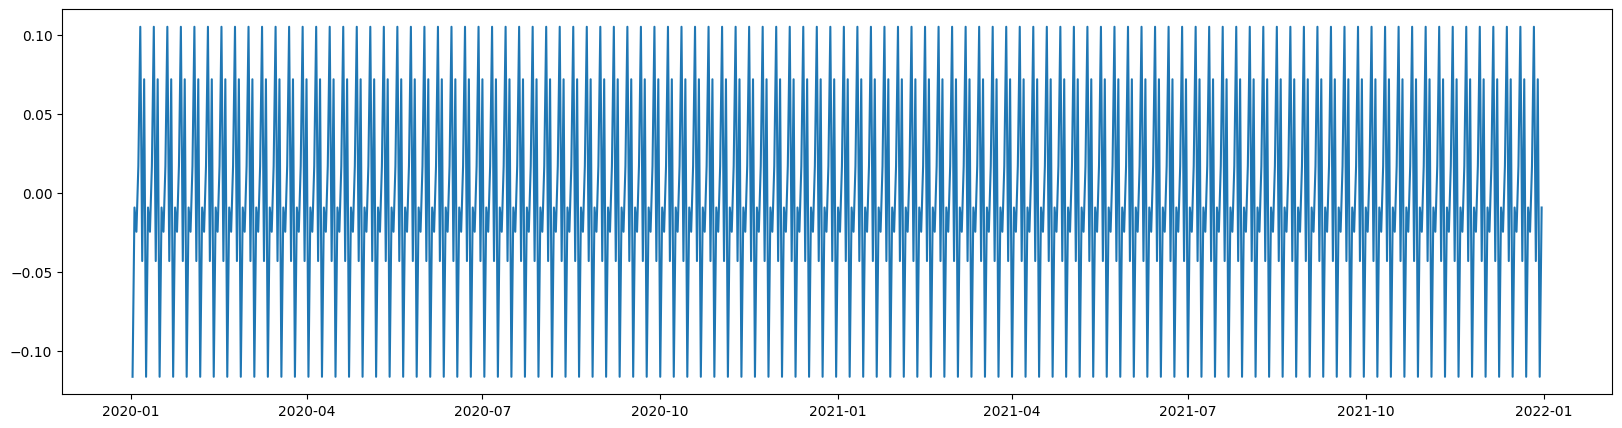

In [1361]:
# Decompose and plot the data to examine seasonality
df_decomposed = seasonal_decompose(df_processed)
plt.figure(figsize = [20,5])
plt.plot(df_decomposed.seasonal)
plt.show()

#### Trends

When looking at the decomposed data, we can observe that the mean hovers around 0.0, indicating that there is not a significant trend in the decomposed time series data, although there may be a few outliers in March of 2020.

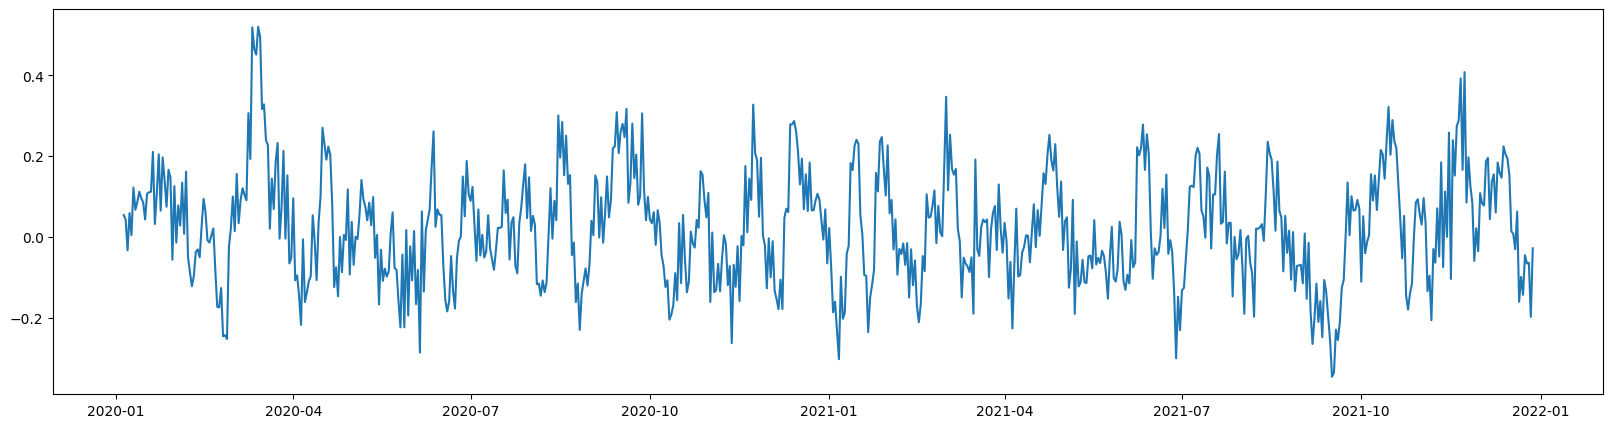

In [1362]:
#Plot the trend of the decomposed data
plt.figure(figsize = [20,5])
plt.plot(df_decomposed.trend)
plt.show()

#### Autocorrelation Function

As we can see from visualizations of the ACF and PACF functions, the ACF tails off at around 2, and the PACF cuts off at 1. Based on these results, we can determine that the most appropriate model for this time series will be an autoregressive model of order 1 (Nau, 2020).

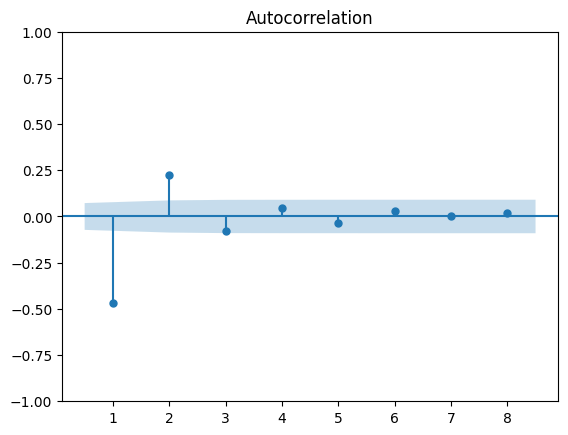

In [1363]:
x = plot_acf(df_processed, lags=8, zero=False)

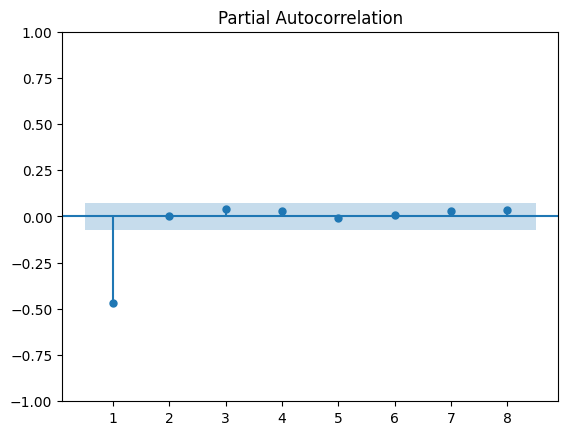

In [1364]:
x = plot_pacf(df_processed, lags=8, zero=False, method='ywm')

#### Spectral Density

Generating a spectral density plot will help us to understand recurring patterns in our time series of daily revenue. In our own analysis, we see that our plot is extremely noisy, has few discernible patterns, and most PSD values fall well below 0, indicating that the frequency components of this time series exhibit little or no amplitude.

A spectral density plot of the transformed time series can be generated by executing the following code:

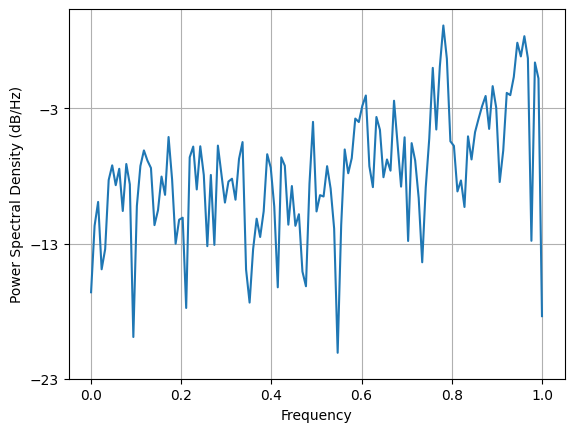

In [1365]:
plt.psd(x=df_processed['Revenue'])
plt.show()

#### Decomposed Time Series

The following code generates the component metrics of the decomposed time series, including the original decomposed time series, the trend of the series, the seasonality, and a plot of the residuals-- random fluctuations and errors that are unexplained by the trend and seasonality:

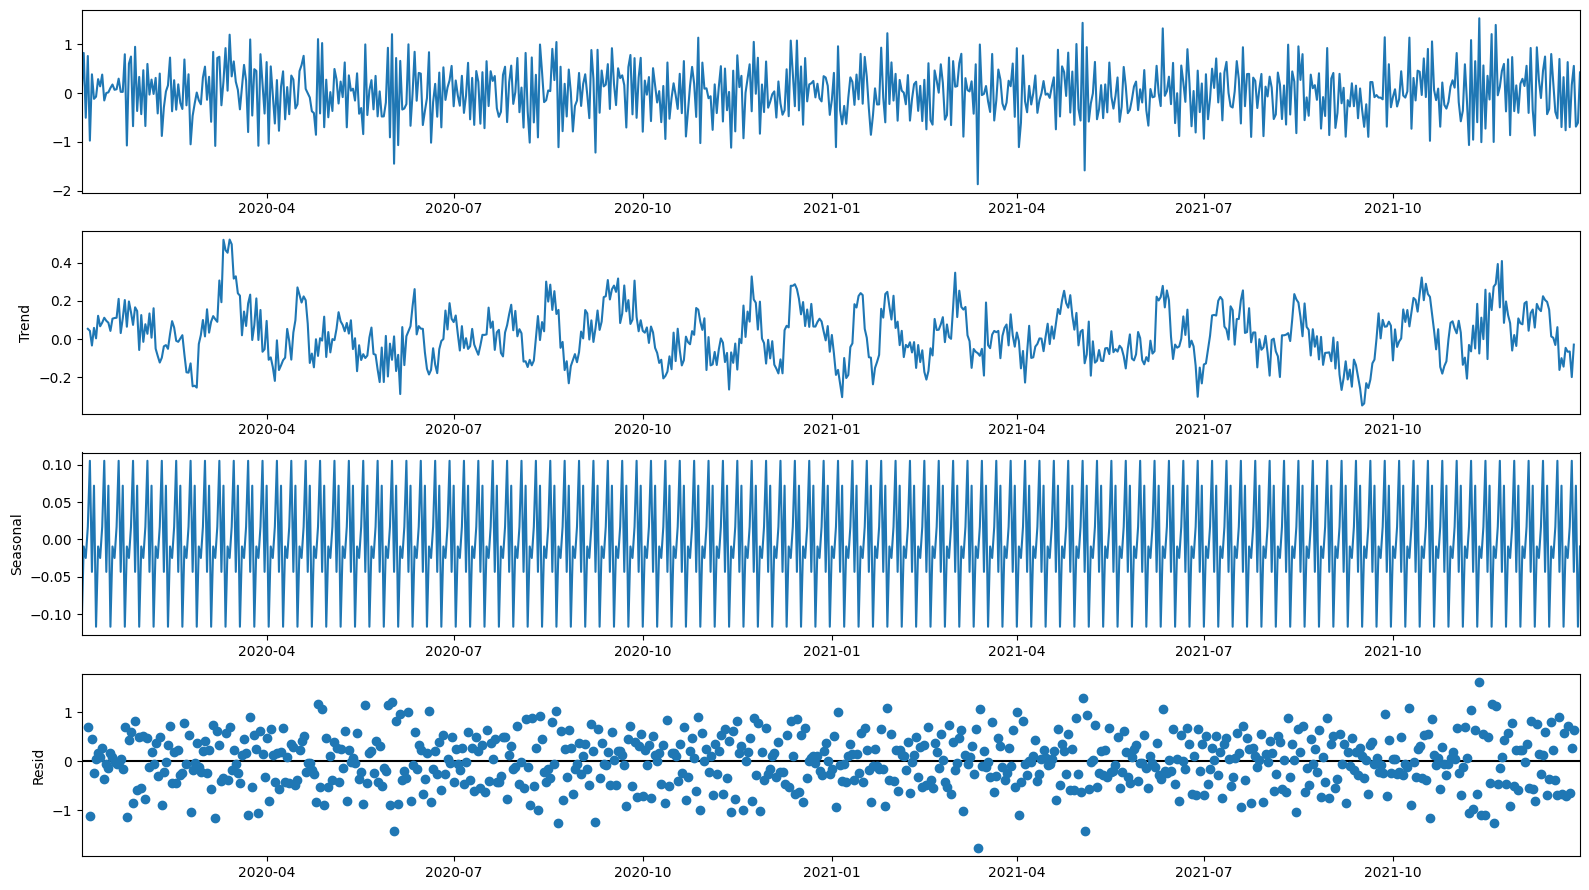

In [1366]:
x= df_decomposed.plot()
x.set_size_inches((16, 9))
# Tight layout to realign things
x.tight_layout()
plt.show()

#### Confirmation of the Lack of Trends in the Residuals of the Decomposed Time Series

The following code plots the residuals in the decomposed time series. As we can see from the chart, there is no identifiable trend in the decomposed residuals, as they all hover around 0.0.

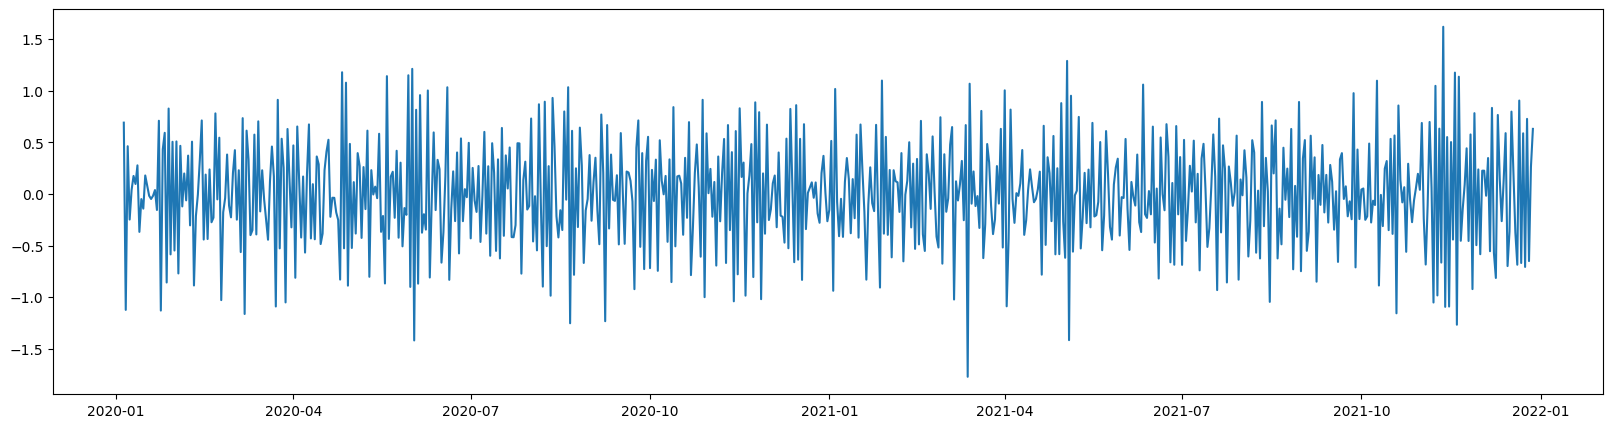

In [1367]:
#Plot the residuals of the decomoposed data
plt.figure(figsize = [20,5])
plt.plot(df_decomposed.resid)
plt.show()

### D2: ARIMA MODEL

As we established in section D1, the model best suited to this time series analysis is an autoregressive model with an order of 1, also known as an AR(1) model.

The following code will instantiate and fit our ARIMA model and fit it to the training data.

In [1368]:
#Instantiate and train our ARIMA model
model = ARIMA(X_train, order=(1, 1, 1))
model_trained = model.fit()
print(model_trained.summary())

                               SARIMAX Results                                
Dep. Variable:                Revenue   No. Observations:                  584
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -387.351
Date:                Fri, 30 Jun 2023   AIC                            780.702
Time:                        15:19:42   BIC                            793.807
Sample:                    01-02-2020   HQIC                           785.810
                         - 08-07-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4587      0.037    -12.556      0.000      -0.530      -0.387
ma.L1         -0.9998      0.162     -6.173      0.000      -1.317      -0.682
sigma2         0.2184      0.037      5.957      0.0

c:\Users\johnf\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\johnf\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\johnf\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


### D3: FORECASTING USING ARIMA MODEL

The following code will forecast and visualize the remaining 20 percent of the data using our ARIMA model:

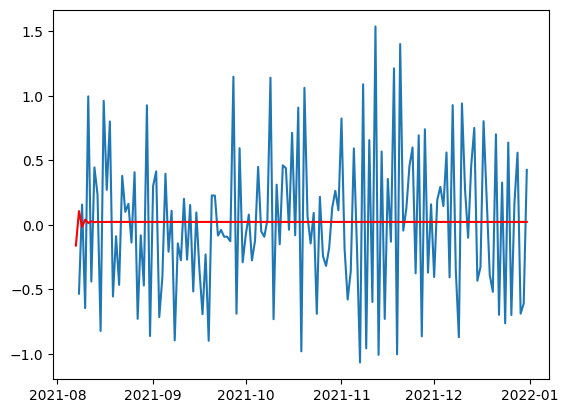

In [1369]:
# Start the forecasting at the index of the split of our training and testing sets, 
# and end at the final index of the df minus 2 to account for the lag in prediction
projection = model_trained.get_prediction(start = int(len(df)*(1-split_size)-1), end =(len(df)-2), dynamic = True)

plt.plot(X_test)
plt.plot(projection.predicted_mean, color='r')
plt.show()

In [1370]:
#Place the forecasted differences into a temporary dataframe and rename it to Revenue
projected_df = pd.DataFrame(projection.predicted_mean)
projected_df = projected_df.rename(columns={'predicted_mean' : 'Revenue'})
#Make copies of the dataframes so the originals are not concatenated
X_trainX= X_train.copy(deep=True)
projected_dfX= projected_df.copy(deep=True)
#Concatenate the dataframes, then get the cumulative sums of the revenue values to reverse the differencing
projected_df_vis = (pd.concat([X_trainX, projected_dfX])).cumsum()
#Replace the values of X_train df with NaN so they don't display on our visualization
projected_df_vis.loc[:len(X_train), 'Revenue'] = np.nan
print(projected_df_vis)

              Revenue
2020-01-02        NaN
2020-01-03        NaN
2020-01-04        NaN
2020-01-05        NaN
2020-01-06        NaN
...               ...
2021-12-27  16.840618
2021-12-28  16.863565
2021-12-29  16.886511
2021-12-30  16.909458
2021-12-31  16.932404

[731 rows x 1 columns]


C:\Users\johnf\AppData\Local\Temp\ipykernel_27096\3224501167.py:10: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  projected_df_vis.loc[:len(X_train), 'Revenue'] = np.nan


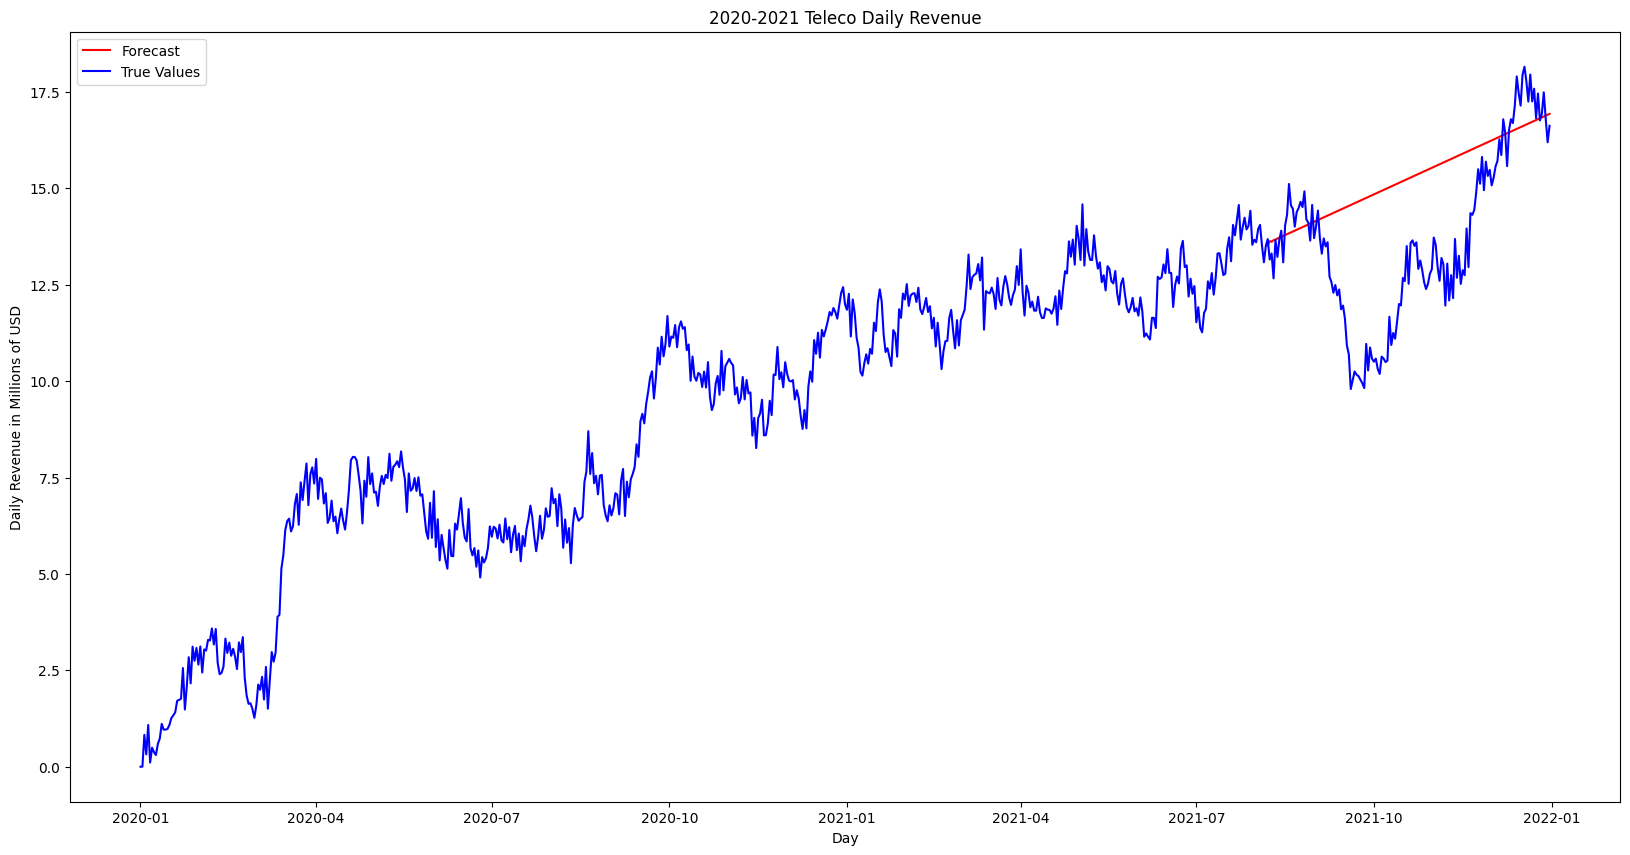

In [1371]:
#Plot our actual data along with the ARIMA forecast of the last 20% of the data
plt.figure(figsize = [20,10])
plt.title("2020-2021 Teleco Daily Revenue")
plt.xlabel("Day")
plt.ylabel("Daily Revenue in Millions of USD")
plt.plot(projected_df_vis, color = 'r')
plt.plot(df, color = 'blue')
plt.legend(['Forecast', 'True Values'])
plt.show()

### D4: OUTPUT AND CALCULATIONS

The tables and visualizations contained in section D3 comprise the forecasting output of the ARIMA model. However, in order to satisfy our research question, we can now generate an MAE using the residuals of our forecast by executing the following code:

In [1372]:
# Calculate root mean squared error of forecasted data against the observed data (both untransformed)
start = df.index.get_loc('2021-08-07')
MAE = mean_absolute_error(df['Revenue'].iloc[start:], projected_df_vis['Revenue'].iloc[start:])
print('MAE = ' + str(MAE))

MAE = 1.895535611123139


In [1373]:
val_range = df['Revenue'].max() - df['Revenue'].min()
print('Value range = ' + str(val_range))

print('MAE / Value range = ' + str(MAE/val_range))

Value range = 18.15476909
MAE / Value range = 0.10440978906017796


### D5: CODE

For continuity, the code used in the completion of this analysis has been executed within its associated rubric section wherever possible. The entirety of the code can be executed at once by pressing the Run All button in the viewer’s preferred Jupyter Notebook environment.

### E1: RESULTS

#### Model Selection

As we can see from the results generated in Section D4, our ARIMA model exhibits an MAE of 1.9504. When we calculate the total range of the time series data and divide our MAE by this range, we can see that our MAE is equivalent to about 10.7% of our total data range. Based on this result, we can conclude that our model does meet our primary goal, having an MAE of less than 15% of the total data range, and that this model can generally be relied upon to produce reasonably accurate forecasting for daily revenue.

#### Prediction Interval

We can calculate the confidence interval by executing the code below. As we can see, our Prediction interval at a confidence value of 95% is 147, or the entirety of the test dataset.

In [1374]:
projection_values = projection.predicted_mean
projection_errors = projection.se_mean

confidence_level = 0.95 
z_score = stats.norm.ppf((1 + confidence_level) / 2)

lower_bound = projection_values - z_score * projection_errors
upper_bound = projection_values + z_score * projection_errors

prediction_interval = pd.concat([lower_bound, upper_bound], axis=1)
prediction_interval.columns = ['Lower Bound', 'Upper Bound']

print(prediction_interval)

            Lower Bound  Upper Bound
2021-08-07    -1.076844     0.756393
2021-08-08    -0.900832     1.114781
2021-08-09    -1.041860     1.010660
2021-08-10    -0.989337     1.070596
2021-08-11    -1.015972     1.045641
...                 ...          ...
2021-12-27    -1.008060     1.053953
2021-12-28    -1.008060     1.053953
2021-12-29    -1.008060     1.053953
2021-12-30    -1.008060     1.053953
2021-12-31    -1.008060     1.053953

[147 rows x 2 columns]


#### Forecast length

The forecast length of this analysis was 147 days, or the entire duration of the 20% testing dataset. Because the type of forecast that we are utilizing is predicated on the time series increasing in a linear fashion, the forecast length is somewhat arbitrary in this case. We selected an 80-20 split because it is an industry standard in this type of regression, but it also gives us ample overhead to utilize this forecast length to anticipate quarterly revenue streams, and nearly allows us to forecast 2 quarters into the future with what is apparently a reasonable degree of accuracy.

#### Model Evaluation and Error Metric

As we can see from the results generated in Section D4, our ARIMA model exhibits an MAE of 1.9504. When we calculate the total range of the time series data and divide our MAE by this range, we can see that our MAE is equivalent to about 10.7% of our total data range. Based on this result, we can conclude that our model does meet our primary goal, having an MAE of less than 15% of the total data range, and that this model can generally be relied upon to produce reasonably accurate forecasting for daily revenue.

While we could instead use RMSE to evaluate our moel, RMSE is more appropriately employed as a metric by which to compare models. Instead, we have elected to evaluate mean absolute error to give a more accurate idea of how the model's raw residuals appear on our actual dataset. Our further evaluation of what percentage of the total data range the MAE represents is simply another way to conceptualize and articulate its final predictive accuracy.

### E2: ANNOTATED VISUALIZATION

For continuity and ease of reference, we will again execute the code necessary to generate our final annotated forecasting visualization.

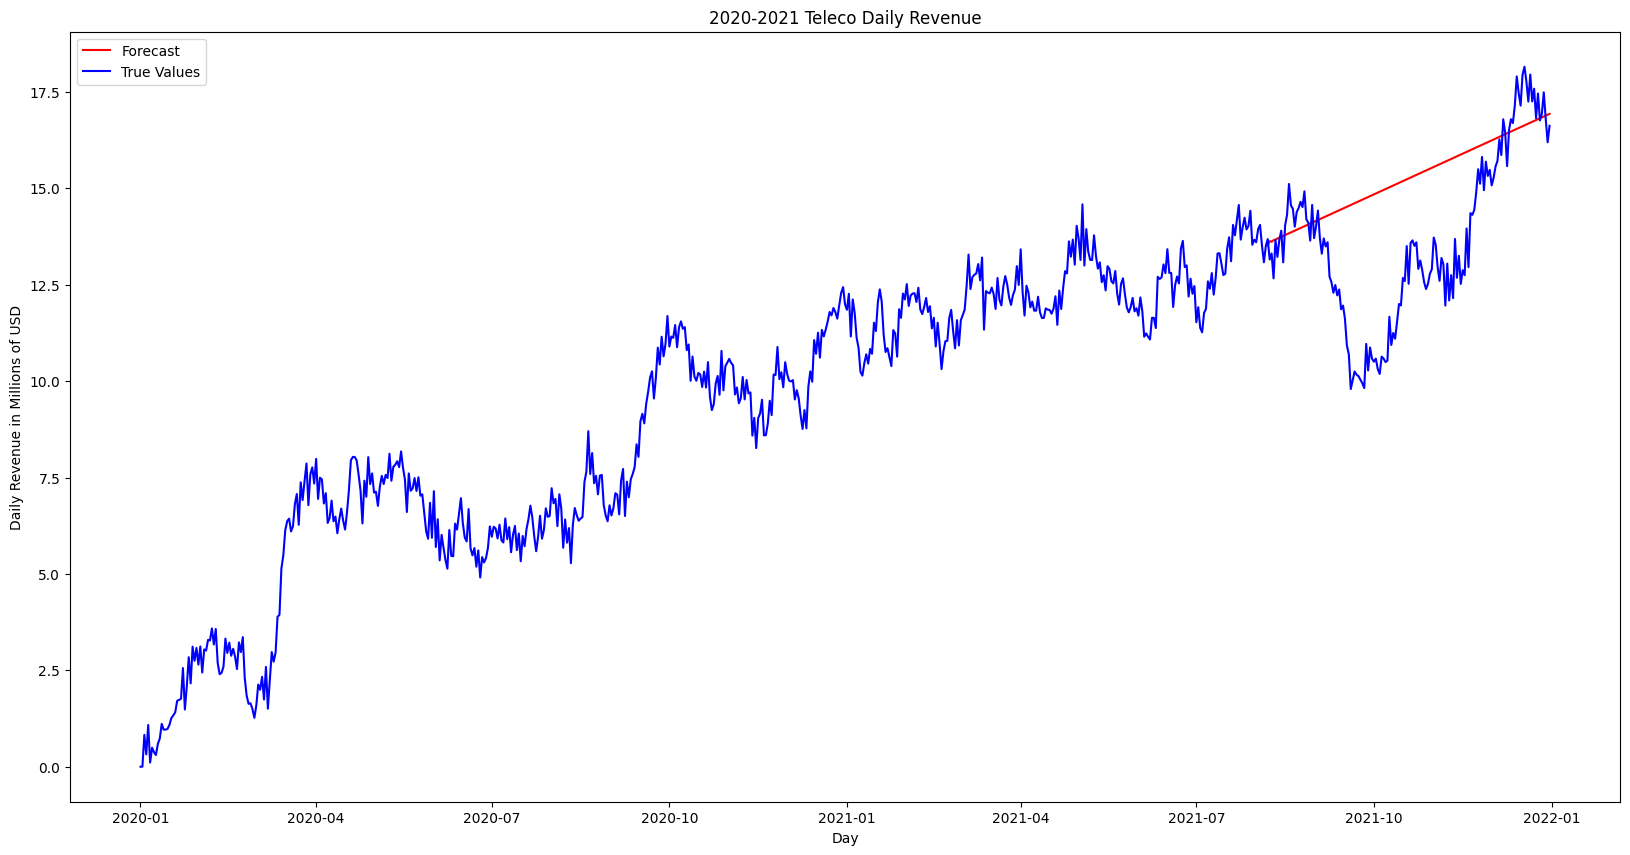

In [1375]:
#Plot our full visualization once again
plt.figure(figsize = [20,10])
plt.title("2020-2021 Teleco Daily Revenue")
plt.xlabel("Day")
plt.ylabel("Daily Revenue in Millions of USD")
plt.plot(projected_df_vis, color = 'r')
plt.plot(df, color = 'blue')
plt.legend(['Forecast', 'True Values'])
plt.show()

### E3: RECOMMENDATION

Based on the results of this analysis, we can recommend that this ARIMA model framework is regularly employed in the planning of organizational budgeting. When used in conjunction with expenditure forecasting, this could allow leadership to make decisions that target specific margin windows and create reasonable metrics for scaling and organizational growth.

### F: REPORTING

In addition to the submission of this notebook file, the executed .ipynb file has also been exported as a .html file and submitted via the WGU portal to comply with this rubric requirement.

### G: SOURCES FOR THIRD-PARTY CODE

The Matplotlib Development Team. (2012-2023). "Matplotlib.dates." https://matplotlib.org/stable/api/dates_api.html#matplotlib.dates.date2num

### H: SOURCES

Nau, R. (2020). "Statistical Forecasting: Notes on Regression and Time Series Analysis." Fuqua School of Business, Duke University. https://people.duke.edu/~rnau/411arim2.htm